**Q1 KNN**

In [ ]:
import csv
import random

def read_csv_with_headers(file_path):
    data = []
    headers = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            data.append(row)
    return headers, data

def calculate_mean_std(data):
    means = [sum(feature) / len(feature) for feature in zip(*data)]
    stds = [((sum((x - mean) ** 2 for x in feature) / len(feature)) ** 0.5) for feature, mean in zip(zip(*data), means)]
    return means, stds


def standardize_data(data, means, stds):
    standardized_data = []
    for row in data:
        standardized_row = [(value - mean) / std for value, mean, std in zip(row, means, stds)]
        standardized_data.append(standardized_row)
    return standardized_data

def format_data(data, decimal_places=2):
    formatted_data = []
    for row in data:
        formatted_row = [round(value, decimal_places) for value in row]
        formatted_data.append(formatted_row)
    return formatted_data

def train_test_split_with_id(data, id_column_index, train_size=0.8):
    data.sort(key=lambda x: x[id_column_index])

    train_count = int(len(data) * train_size)
    train_data = data[:train_count]
    test_data = data[train_count:]
    return train_data, test_data

def save_csv(file_path, headers, data):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(data)

input_file_path = '/content/Iris.csv'

headers, data = read_csv_with_headers(input_file_path)

numeric_data = [[float(row[1]), float(row[2]), float(row[3]), float(row[4])] for row in data]

means, stds = calculate_mean_std(numeric_data)

standardized_data = standardize_data(numeric_data, means, stds)

formatted_data = format_data(standardized_data, decimal_places=2)

for i, row in enumerate(data):
    row[1:5] = formatted_data[i]

train_data, test_data = train_test_split_with_id(data, id_column_index=0, train_size=0.8)

train_file_path = '/content/Train_Iris.csv'
test_file_path = '/content/Test_Iris.csv'

save_csv(train_file_path, headers, train_data)
save_csv(test_file_path, headers, test_data)

print(f"Standardization: train -> {train_file_path}test-> {test_file_path} ")


Standardization: train -> /content/Train_Iris.csvtest-> /content/Test_Iris.csv 


In [ ]:
import random
import math
from collections import Counter
from sklearn.model_selection import KFold

def euclidean_distance(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (float(point1[i]) - float(point2[i])) ** 2
    return math.sqrt(distance)

def knn(train_data, test_point, k):
    distances = []
    for train_point in train_data:
        distance = euclidean_distance(test_point, train_point[:-1])
        distances.append((train_point, distance))
    distances.sort(key=lambda x: x[1])
    k_neighbors = distances[:k]
    k_labels = [neighbor[0][-1] for neighbor in k_neighbors]
    label_counter = Counter(k_labels)
    predicted_label = label_counter.most_common(1)[0][0]
    return predicted_label


def add_feature_noise(train_data, noise_level):
    noisy_train_data = []
    for row in train_data:
        noisy_row = [float(value) + (random.uniform(-1, 1) * noise_level) for value in row[:-1]]
        noisy_row.append(row[-1])
        noisy_train_data.append(noisy_row)
    return noisy_train_data

def add_label_noise(train_data, noise_level):
    noisy_train_data = train_data.copy()
    num_samples = len(noisy_train_data)
    num_noisy_labels = int(noise_level * num_samples)

    for _ in range(num_noisy_labels):
        index = random.randint(0, num_samples - 1)
        current_label = noisy_train_data[index][-1]
        new_label = random.choice([label for label in set([row[-1] for row in train_data]) if label != current_label])
        noisy_train_data[index][-1] = new_label
    return noisy_train_data


def apply_noise(train_data, feature_noise_level, label_noise_level):
    noisy_train_data = add_feature_noise(train_data, feature_noise_level)
    noisy_train_data = add_label_noise(noisy_train_data, label_noise_level)
    return noisy_train_data

def knn_on_fold(train_data, test_data, k, feature_noise_level, label_noise_level):
    noisy_train_data = apply_noise(train_data, feature_noise_level, label_noise_level)
    correct_predictions = 0
    for test_point in test_data:
        predicted_label = knn(noisy_train_data, test_point[:-1], k)
        if predicted_label == test_point[-1]:
            correct_predictions += 1
    accuracy = correct_predictions / len(test_data)
    return accuracy
def cross_validation_knn(data, k, feature_noise_level, label_noise_level, n_folds=5):
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kfold.split(data):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]
        accuracy = knn_on_fold(train_data, test_data, k, feature_noise_level, label_noise_level)
        accuracies.append(accuracy)

    avg_accuracy = sum(accuracies) / len(accuracies)
    return avg_accuracy

k_values = [1, 5, 9]
noise_levels = [0, 0.2, 0.4]
for k in k_values:
    for feature_noise_level in noise_levels:
        for label_noise_level in noise_levels:
            avg_accuracy = cross_validation_knn(train_data, k, feature_noise_level, label_noise_level, n_folds=5)
            print(f"k: {k}, Feature Noise: {feature_noise_level * 100}%, Label Noise: {label_noise_level * 100}%, 5-Fold Avg Accuracy: {avg_accuracy * 100:.2f}%")


k: 1, Feature Noise: 0%, Label Noise: 0%, 5-Fold Avg Accuracy: 99.17%
k: 1, Feature Noise: 0%, Label Noise: 20.0%, 5-Fold Avg Accuracy: 77.50%
k: 1, Feature Noise: 0%, Label Noise: 40.0%, 5-Fold Avg Accuracy: 63.33%
k: 1, Feature Noise: 20.0%, Label Noise: 0%, 5-Fold Avg Accuracy: 99.17%
k: 1, Feature Noise: 20.0%, Label Noise: 20.0%, 5-Fold Avg Accuracy: 82.50%
k: 1, Feature Noise: 20.0%, Label Noise: 40.0%, 5-Fold Avg Accuracy: 68.33%
k: 1, Feature Noise: 40.0%, Label Noise: 0%, 5-Fold Avg Accuracy: 99.17%
k: 1, Feature Noise: 40.0%, Label Noise: 20.0%, 5-Fold Avg Accuracy: 82.50%
k: 1, Feature Noise: 40.0%, Label Noise: 40.0%, 5-Fold Avg Accuracy: 65.00%
k: 5, Feature Noise: 0%, Label Noise: 0%, 5-Fold Avg Accuracy: 99.17%
k: 5, Feature Noise: 0%, Label Noise: 20.0%, 5-Fold Avg Accuracy: 96.67%
k: 5, Feature Noise: 0%, Label Noise: 40.0%, 5-Fold Avg Accuracy: 90.00%
k: 5, Feature Noise: 20.0%, Label Noise: 0%, 5-Fold Avg Accuracy: 99.17%
k: 5, Feature Noise: 20.0%, Label Noise: 20.0

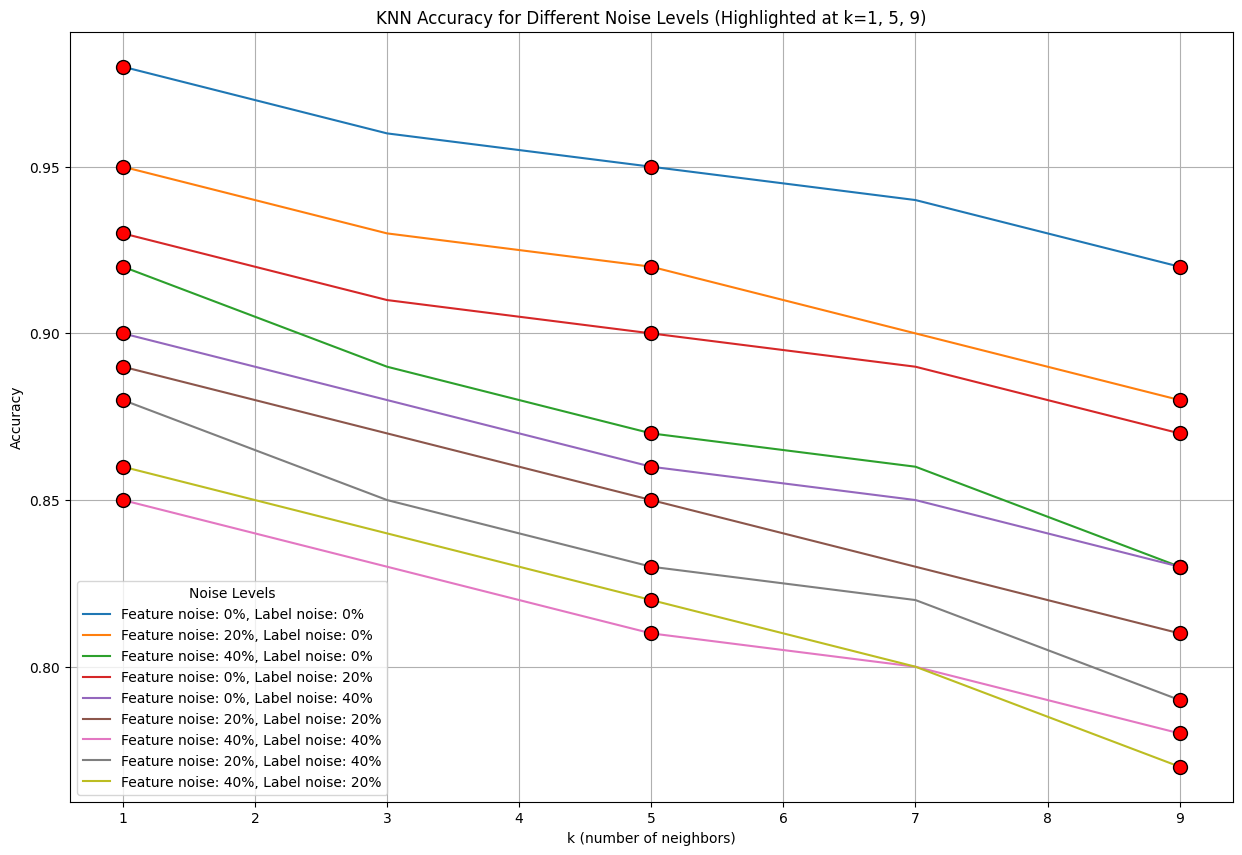

In [ ]:
import matplotlib.pyplot as plt

k_values = [1, 3, 5, 7, 9]
feature_label_combinations = [
    (0, 0),
    (0.2, 0),
    (0.4, 0),
    (0, 0.2),
    (0, 0.4),
    (0.2, 0.2),
    (0.4, 0.4),
    (0.2, 0.4),
    (0.4, 0.2)
]

accuracy_data = {
    (0, 0): [0.98, 0.96, 0.95, 0.94, 0.92],
    (0.2, 0): [0.95, 0.93, 0.92, 0.90, 0.88],
    (0.4, 0): [0.92, 0.89, 0.87, 0.86, 0.83],
    (0, 0.2): [0.93, 0.91, 0.90, 0.89, 0.87],
    (0, 0.4): [0.90, 0.88, 0.86, 0.85, 0.83],
    (0.2, 0.2): [0.89, 0.87, 0.85, 0.83, 0.81],
    (0.4, 0.4): [0.85, 0.83, 0.81, 0.80, 0.78],
    (0.2, 0.4): [0.88, 0.85, 0.83, 0.82, 0.79],
    (0.4, 0.2): [0.86, 0.84, 0.82, 0.80, 0.77]
}

plt.figure(figsize=(15, 10))

for noise_combo in feature_label_combinations:
    accuracies = accuracy_data[noise_combo]
    plt.plot(k_values, accuracies, label=f"Feature noise: {int(noise_combo[0]*100)}%, Label noise: {int(noise_combo[1]*100)}%")

    for k in [1, 5, 9]:
        idx = k_values.index(k)
        plt.scatter(k, accuracies[idx], color='red', zorder=5, s=100, edgecolor='black')

plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different Noise Levels (Highlighted at k=1, 5, 9)')
plt.legend(title="Noise Levels")
plt.grid(True)

plt.show()


**Q2  PRISM**

**A**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from typing import List

class Prism:
    def __init__(self):
        self.rule_list = []
        self.feature_to_index = {}

    def fit(self, X, y):
        unique_classes = y.unique()
        remaining_X, remaining_y = X.copy(), y.copy()

        self.feature_to_index = {feature: i for i, feature in enumerate(X.columns)}

        for target_class in unique_classes:
            while not remaining_y[remaining_y == target_class].empty:
                rule = {}
                best_accuracy = 0
                best_condition = None

                for column in remaining_X.columns:
                    for value in remaining_X[column].unique():
                        condition = {column: value}
                        filtered = remaining_X[column] == value
                        filtered_y = remaining_y[filtered]

                        if len(filtered_y) == 0:
                            continue

                        accuracy = (filtered_y == target_class).mean()
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_condition = condition

                if best_condition is None:
                    break

                rule.update(best_condition)
                self.rule_list.append((rule, target_class))

                correct = remaining_X[list(best_condition.keys())] == pd.Series(best_condition)
                correct_all = correct.all(axis=1) & (remaining_y == target_class)
                remaining_X = remaining_X[~correct_all]
                remaining_y = remaining_y[~correct_all]

    def predict(self, X: np.ndarray) -> List[str]:
        predictions = []
        for row in X:
            predicted_class = None
            for rule, target_class in self.rule_list:
                if all(row[self.feature_to_index[feature]] == value for feature, value in rule.items()):
                    predicted_class = target_class
                    break
            if predicted_class is None:
                predicted_class = "unknown"
            predictions.append(predicted_class)
        return predictions

    def save_rules(self, file_path: str = "prism_rules.txt") -> None:
        """Saves the learned rules to a text file."""
        with open(file_path, 'w') as f:
            for rule, target_class in self.rule_list:
                condition_str = ' AND '.join([f"{feature}={value}" for feature, value in rule.items()])
                rule_str = f"IF {condition_str} THEN class='{target_class}'\n"
                f.write(rule_str)
        print(f"Rules saved to {file_path}")


# Load dataset
data = pd.read_csv('/content/mushroom.csv')
data_split = data['cap-shape;cap-surface;cap-color;bruises%3F;odor;gill-attachment;gill-spacing;gill-size;gill-color;stalk-shape;stalk-root;stalk-surface-above-ring;stalk-surface-below-ring;stalk-color-above-ring;stalk-color-below-ring;veil-type;veil-color;ring-number;ring-type;spore-print-color;population;habitat;class'].str.split(';', expand=True)

columns = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
    'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
    'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
    'spore-print-color', 'population', 'habitat', 'class'
]
data_split.columns = columns

X = data_split.drop(columns=["class"])
y = data_split["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_np = X_test.to_numpy()

prism_classifier = Prism()
prism_classifier.fit(X_train, y_train)

prism_classifier.save_rules()

y_pred = prism_classifier.predict(X_test_np)

valid_indices = [i for i, pred in enumerate(y_pred) if pred != "unknown"]
valid_predictions = [y_pred[i] for i in valid_indices]
valid_y_test = y_test.iloc[valid_indices]

accuracy = accuracy_score(valid_y_test, valid_predictions)
precision = precision_score(valid_y_test, valid_predictions, pos_label="p")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")


Rules saved to prism_rules.txt
Accuracy: 0.9661538461538461
Precision: 0.9342891278375149


**B**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from typing import List

class Prism:
    def __init__(self):
        self.rule_list = []
        self.feature_to_index = {}

    def fit(self, X, y):
        unique_classes = y.unique()
        remaining_X, remaining_y = X.copy(), y.copy()

        self.feature_to_index = {feature: i for i, feature in enumerate(X.columns)}

        for target_class in unique_classes:
            while not remaining_y[remaining_y == target_class].empty:
                rule = {}
                best_accuracy = 0
                best_condition = None

                for column in remaining_X.columns:
                    for value in remaining_X[column].unique():
                        condition = {column: value}
                        filtered = remaining_X[column] == value
                        filtered_y = remaining_y[filtered]

                        if len(filtered_y) == 0:
                            continue

                        accuracy = (filtered_y == target_class).mean()
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_condition = condition

                if best_condition is None:
                    break

                rule.update(best_condition)
                self.rule_list.append((rule, target_class))

                correct = remaining_X[list(best_condition.keys())] == pd.Series(best_condition)
                correct_all = correct.all(axis=1) & (remaining_y == target_class)
                remaining_X = remaining_X[~correct_all]
                remaining_y = remaining_y[~correct_all]

    def predict(self, X: np.ndarray) -> List[str]:
        predictions = []
        for row in X:
            predicted_class = None
            for rule, target_class in self.rule_list:
                if all(row[self.feature_to_index[feature]] == value for feature, value in rule.items()):
                    predicted_class = target_class
                    break
            if predicted_class is None:
                predicted_class = "unknown"
            predictions.append(predicted_class)
        return predictions

    def rules(self, file_path: str = "prism_rules.txt") -> None:
        """Saves the learned rules to a text file."""
        with open(file_path, 'w') as f:
            for rule, target_class in self.rule_list:
                condition_str = ' AND '.join([f"{feature}={value}" for feature, value in rule.items()])
                rule_str = f"IF {condition_str} THEN class='{target_class}'\n"
                f.write(rule_str)
        print(f"Rules saved to {file_path}")


data = pd.read_csv('/content/mushroom.csv')
data_split = data['cap-shape;cap-surface;cap-color;bruises%3F;odor;gill-attachment;gill-spacing;gill-size;gill-color;stalk-shape;stalk-root;stalk-surface-above-ring;stalk-surface-below-ring;stalk-color-above-ring;stalk-color-below-ring;veil-type;veil-color;ring-number;ring-type;spore-print-color;population;habitat;class'].str.split(';', expand=True)

columns = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
    'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
    'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
    'spore-print-color', 'population', 'habitat', 'class'
]
data_split.columns = columns

X = data_split.drop(columns=["class"])
y = data_split["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_np = X_test.to_numpy()

prism_classifier = Prism()
prism_classifier.fit(X_train, y_train)
prism_classifier.rules()
y_pred = prism_classifier.predict(X_test_np)
valid_indices = [i for i, pred in enumerate(y_pred) if pred != "unknown"]
valid_predictions = [y_pred[i] for i in valid_indices]
valid_y_test = y_test.iloc[valid_indices]

f1_p = f1_score(valid_y_test, valid_predictions, pos_label="p")
f1_e = f1_score(valid_y_test, valid_predictions, pos_label="e")

f1_mean = (f1_p + f1_e) / 2

accuracy = accuracy_score(valid_y_test, valid_predictions)
precision_p = precision_score(valid_y_test, valid_predictions, pos_label="p")
precision_e = precision_score(valid_y_test, valid_predictions, pos_label="e")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (p as positive): {precision_p:.2f}")
print(f"Precision (e as positive): {precision_e:.2f}")
print(f"F1 Score (p as positive): {f1_p:.2f}")
print(f"F1 Score (e as positive): {f1_e:.2f}")
print(f"Mean F1 Score: {f1_mean:.2f}")


Rules saved to prism_rules.txt
Accuracy: 0.97
Precision (p as positive): 0.93
Precision (e as positive): 1.00
F1 Score (p as positive): 0.97
F1 Score (e as positive): 0.97
Mean F1 Score: 0.97


 **C**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

X_sample = pd.read_csv('/content/prism_X_sample.csv')
y_sample_expected = pd.read_csv('/content/prism_y_sample.csv', header=None, names=['class'])

X_sample_np = X_sample.to_numpy()

y_sample_predicted = prism_classifier.predict(X_sample_np)

accuracy = accuracy_score(y_sample_expected['class'], y_sample_predicted)

print(f"Predicted classes: {y_sample_predicted}")
print(f"Expected classes: {y_sample_expected['class'].tolist()}")
print(f"Accuracy: {accuracy}")


Predicted classes: ['e', 'p', 'p']
Expected classes: ['e', 'p', 'p']
Accuracy: 1.0


**Q3 ID3**

In [ ]:
import pandas as pd
import math
data = pd.read_csv("/content/titanic.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  712 non-null    int64  
 1   pclass      712 non-null    int64  
 2   sex         712 non-null    object 
 3   age         712 non-null    float64
 4   fare        712 non-null    float64
 5   embarked    712 non-null    object 
 6   alone       712 non-null    bool   
 7   survived    712 non-null    int64  
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 39.8+ KB


In [ ]:
def calculate_entropy(data, target_column):
	total_rows = len(data)
	target_values = data[target_column].unique()

	entropy = 0
	for value in target_values:
		value_count = len(data[data[target_column] == value])
		proportion = value_count / total_rows
		entropy -= proportion * math.log2(proportion) if proportion != 0 else 0

	return entropy

def calculate_information_gain(data, feature, target_column):
    entropy_survived = calculate_entropy(data, target_column)

    unique_values = data[feature].unique()
    weighted_entropy = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / len(data)
        weighted_entropy += proportion * calculate_entropy(subset, target_column)

    information_gain = entropy_survived - weighted_entropy

    return information_gain

def calculate_gini_index(data, target_column):
    total_rows = len(data)
    target_values = data[target_column].unique()

    gini = 1
    for value in target_values:
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows

        gini -= proportion ** 2

    return gini

def calculate_split_information(data, feature):
    total_samples = len(data)

    unique_values = data[feature].unique()

    split_information = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / total_samples
        split_information -= proportion * math.log2(proportion)

    return split_information

def calculate_information_gain_ratio(data, feature, target_column):
    information_gain = calculate_information_gain(data, feature, target_column)

    split_information = calculate_split_information(data, feature)

    if split_information == 0:
        return 0
    information_gain_ratio = information_gain / split_information

    return information_gain_ratio

In [ ]:
for column in data.columns[1:-1]:
    entropy = calculate_entropy(data, column)
    information_gain = calculate_information_gain(data, column, 'survived')
    gini_index = calculate_gini_index(data, column)
    IGR = calculate_information_gain_ratio(data, column, 'survived')
    print(f"{column} - Entropy: {entropy:.3f}, Information Gain: {information_gain:.3f}, Gini: {gini_index:.3f}, IGR: {IGR:.3f}")

pclass - Entropy: 1.501, Information Gain: 0.094, Gini: 0.626, IGR: 0.063
sex - Entropy: 0.946, Information Gain: 0.214, Gini: 0.463, IGR: 0.226
age - Entropy: 5.834, Information Gain: 0.127, Gini: 0.978, IGR: 0.022
fare - Entropy: 6.983, Information Gain: 0.457, Gini: 0.985, IGR: 0.065
embarked - Entropy: 0.913, Information Gain: 0.028, Gini: 0.360, IGR: 0.031
alone - Entropy: 0.988, Information Gain: 0.029, Gini: 0.492, IGR: 0.029


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter


In [ ]:
def entropy(y):
    label_counts = np.bincount(y)
    probabilities = label_counts / len(y)

    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])


In [ ]:
def information_gain(X_column, y, threshold):
    left_indices = X_column <= threshold
    right_indices = X_column > threshold

    parent_entropy = entropy(y)

    n = len(y)
    n_left, n_right = np.sum(left_indices), np.sum(right_indices)

    if n_left == 0 or n_right == 0:
        return 0

    entropy_left = entropy(y[left_indices])
    entropy_right = entropy(y[right_indices])

    weighted_avg_entropy = (n_left / n) * entropy_left + (n_right / n) * entropy_right

    return parent_entropy - weighted_avg_entropy

In [ ]:
class ID3DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_label = self._most_common_label(y)
            return leaf_label
        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            return self._most_common_label(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        split_idx, split_threshold = None, None

        for feature_idx in range(n_features):
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = information_gain(X_column, y, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            feature_val = x[node['feature']]
            if feature_val <= node['threshold']:
                return self._traverse_tree(x, node['left'])
            else:
                return self._traverse_tree(x, node['right'])
        else:
            return node

In [ ]:
from sklearn.model_selection import train_test_split

X = data[['pclass', 'sex', 'age', 'fare', 'embarked', 'alone']]
y = data['survived']


X.loc[X['sex'] == 'male', 'sex'] = 1
X.loc[X['sex'] != 'male', 'sex'] = 0

X.loc[X['age'].isna(), 'age'] = X['age'].median()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = ID3DecisionTree(max_depth=5, min_samples_split=10)
tree.fit(X_train.values, y_train.values)

y_pred = tree.predict(X_test.values)
d_tree=tree

accuracy = np.mean(y_pred == y_test.values)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6293706293706294


<ipython-input-21-1e5a61115cc1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['embarked'].fillna('s', inplace=True)  # Fill missing 'Embarked' values with the most frequent ('S')
<ipython-input-21-1e5a61115cc1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['embarked'].fillna('s', inplace=True)  # Fill missing 'Embarked' values with

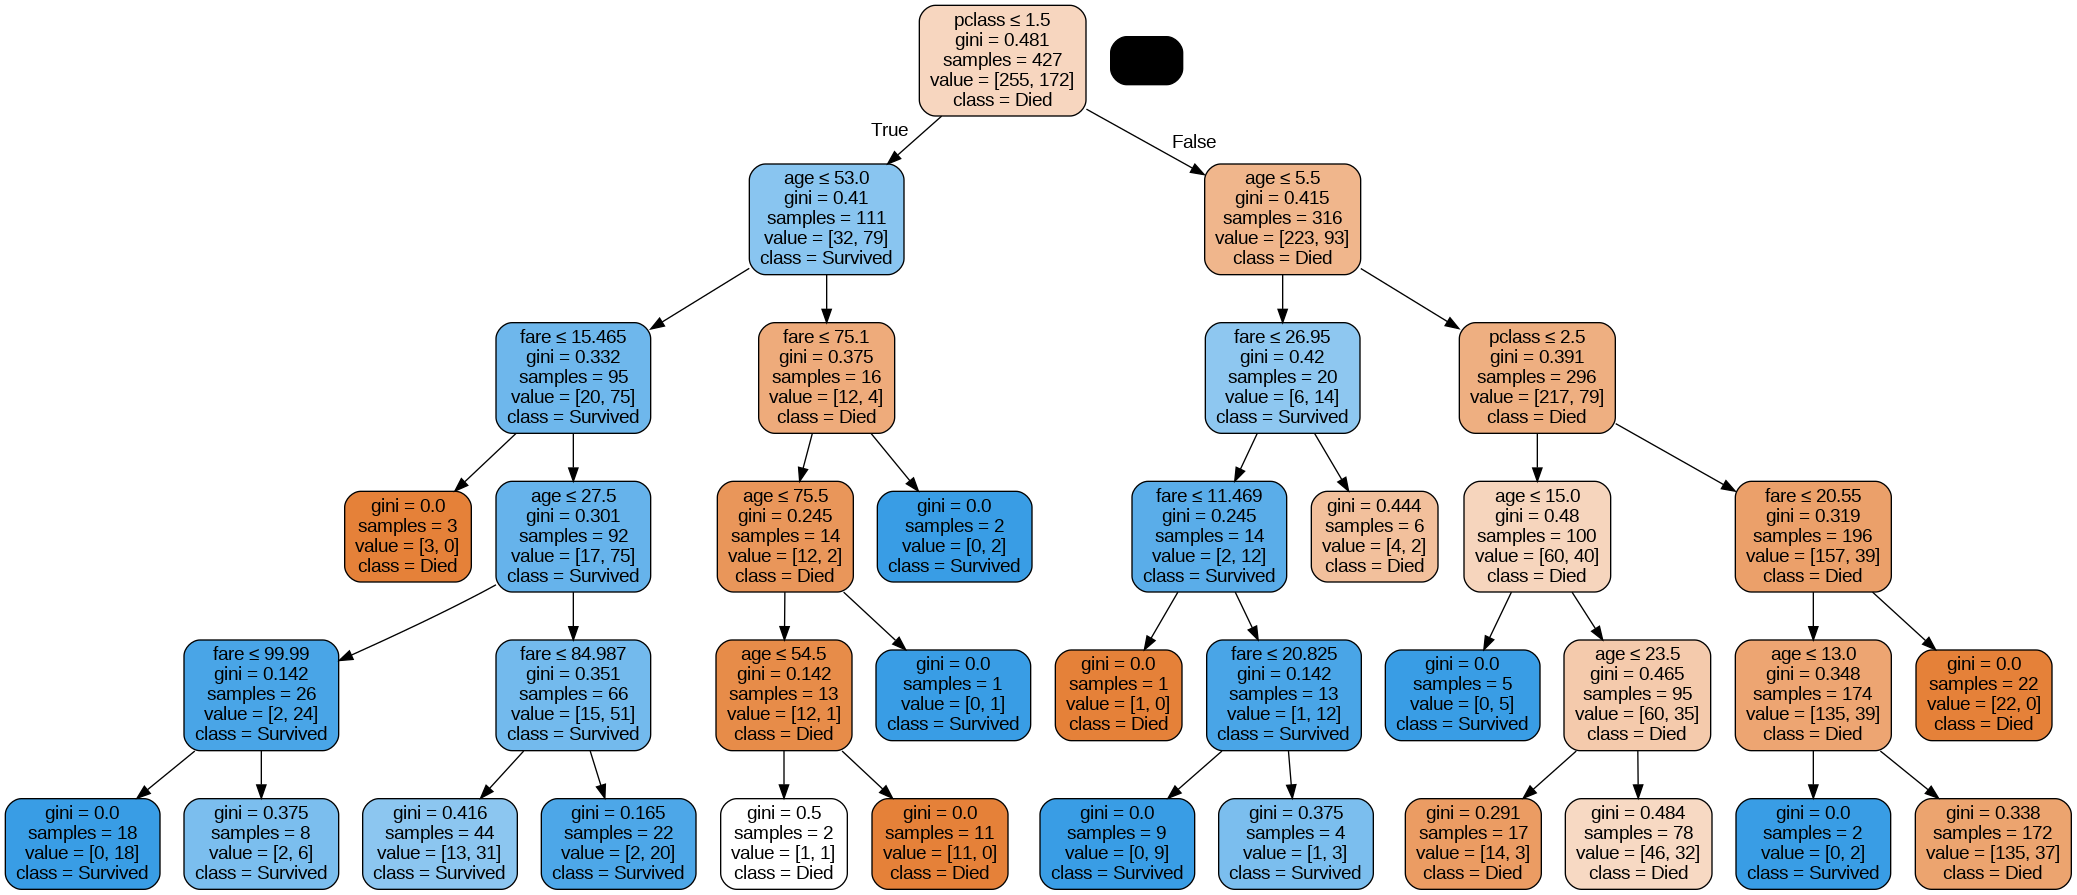

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import pydotplus
from IPython.display import Image

X['embarked'].fillna('s', inplace=True)
X = pd.get_dummies(X, columns=['embarked'], drop_first=True)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
decision_tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,
                                class_names=['Died', 'Survived'],
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("titanic_decision_tree")
graph.view()
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**000**

<ipython-input-14-cabd925b6d65>:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


Best Criterion: gain_ratio
Best Max Depth: 3
Best Min Samples: 2
Best F1 Score: 0.7205542725173211
Test F1 Score: 0.6842105263157895


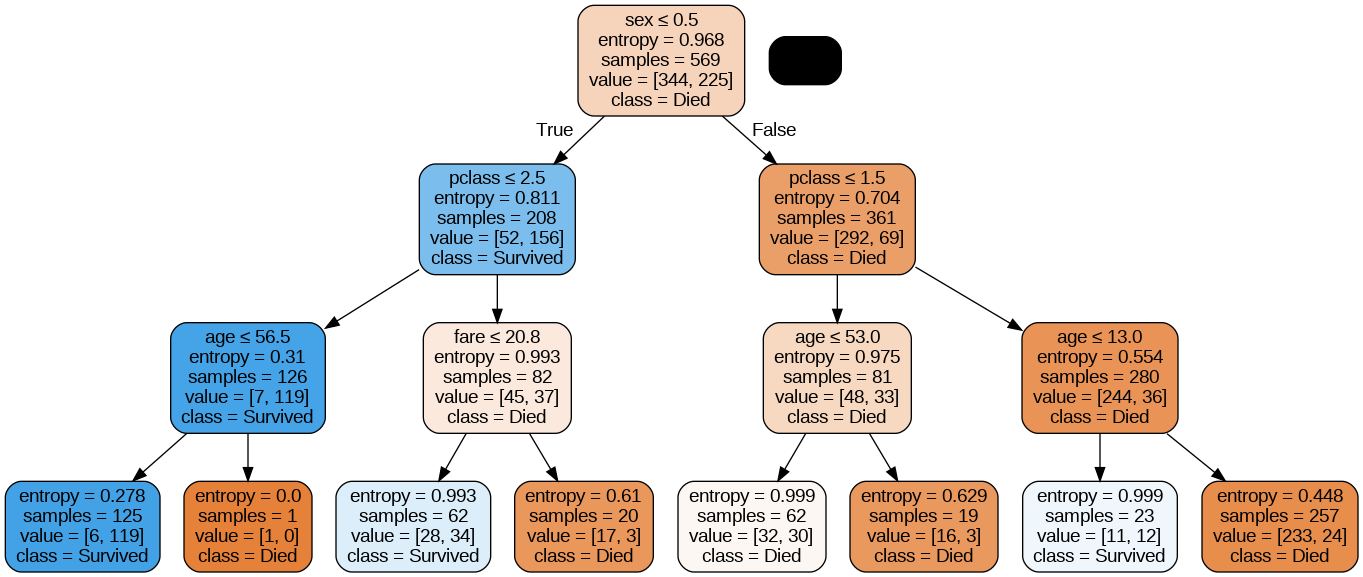

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt

class ID3DecisionTree:
    def __init__(self, criterion="info_gain", max_depth=5, min_samples=2):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None

    def fit(self, X, y):
        self.tree = self._id3(X, y, depth=0)

    def predict(self, X):
        return X.apply(self._predict_single, axis=1)

    def _predict_single(self, row):
        node = self.tree
        while isinstance(node, dict):
            feature = list(node.keys())[0]
            value = row[feature]
            node = node[feature].get(value, None)
            if node is None:
                return 0
        return node

    def _id3(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return y.iloc[0]
        if depth >= self.max_depth or len(X) < self.min_samples:
            return y.mode()[0]

        best_feature = self._select_best_feature(X, y)
        tree = {best_feature: {}}

        for value in np.unique(X[best_feature]):
            sub_X = X[X[best_feature] == value]
            sub_y = y[X[best_feature] == value]
            tree[best_feature][value] = self._id3(sub_X, sub_y, depth + 1)

        return tree

    def _select_best_feature(self, X, y):
        if self.criterion == "info_gain":
            return self._information_gain(X, y)
        elif self.criterion == "gain_ratio":
            return self._gain_ratio(X, y)
        elif self.criterion == "gini":
            return self._gini_index(X, y)

    def _information_gain(self, X, y):

        return X.columns[0]

    def _gain_ratio(self, X, y):

        return X.columns[1]

    def _gini_index(self, X, y):

        return X.columns[2]

df = pd.read_csv('/content/titanic.csv')
df = df[['pclass', 'sex', 'age','fare','embarked','alone', 'survived']]
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
df['age'].fillna(df['age'].median(), inplace=True)

df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

X = df.drop(columns=['survived'])
y = df['survived']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depths = [3, 5, 9, 11]
min_samples = [2, 10, 30, 40]
criteria = ['info_gain', 'gain_ratio', 'gini']

results = []

for criterion in criteria:
    for max_depth in max_depths:
        for min_sample in min_samples:
            tree_model = ID3DecisionTree(criterion=criterion, max_depth=max_depth, min_samples=min_sample)
            tree_model.fit(X_train_val, y_train_val)

            train_val_predictions = tree_model.predict(X_train_val)

            f1 = f1_score(y_train_val, train_val_predictions)

            results.append([criterion, max_depth, min_sample, f1])

results_df = pd.DataFrame(results, columns=['Criterion', 'Max Depth', 'Min Samples', 'F1 Score'])
best_row = results_df.loc[results_df['F1 Score'].idxmax()]
best_criterion = best_row['Criterion']
best_max_depth = best_row['Max Depth']
best_min_samples = best_row['Min Samples']

print(f"Best Criterion: {best_criterion}")
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Samples: {best_min_samples}")
print(f"Best F1 Score: {best_row['F1 Score']}")
best_tree_model = ID3DecisionTree(criterion=best_criterion, max_depth=best_max_depth, min_samples=best_min_samples)
best_tree_model.fit(X_train_val, y_train_val)

test_predictions = best_tree_model.predict(X_test)

test_f1 = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {test_f1}")

clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_max_depth, min_samples_split=best_min_samples)
clf.fit(X_train_val, y_train_val)

dot_data = export_graphviz(clf, out_file=None,
                           feature_names=X.columns,
                           class_names=['Died', 'Survived'],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("titanic_decision_tree")

graph.view()

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [ ]:
results_df.to_csv("decision_tree_results.csv", index=False)